# Autoencoder (compression)
--- 

In this notebook we will train a fully connected (dense) autoencoder on the nasa data set.

The keras code was inspired by https://blog.keras.io/building-autoencoders-in-keras.html

In [ ]:
# inports
import numpy as np

import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import TensorBoard

from util import plot_spectrogram_features
from util import plot_reconstruction_error
from util import load_data
from util import scale

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
print(keras.__version__)

In [41]:
# auxiliary variable
tensorboard_path = "./"

## Load NASA data

In [42]:
path = "./features_nasa.pickle"
X_train, X_test = load_data(path)

---

## Build Model

In [43]:
# input dim
n_features = X_train.shape[1] 
# number of hidden units
encoding_dim = 4 # 4 floats --> compression of factor 25, assuming the input is 100 floats

print("Number of features:", n_features)
print("Number of hidden units:", encoding_dim)

Number of features: 100
Number of hidden units: 4


In [44]:
# Create model
model = Sequential()
model.add(Dense(input_shape=(n_features,), units=encoding_dim, activation='sigmoid'))
# now the model will take as input arrays of shape (*, n_features)
# and output arrays of shape (*, encoding_dim)
model.add(Dense(units=n_features, activation='sigmoid'))

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 404       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               500       
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Optimizer stochastic gradient descent
sgd = optimizers.SGD(learning_rate=0.2, decay=1e-6, momentum=0.9, nesterov=True)

In [47]:
# Compile model
model.compile(optimizer=sgd, loss='mean_squared_error')

### Prepare data

In [48]:
# Normalization (choose one sensor)
nb_sensor = 0
x_train = scale(X_train[:,:,nb_sensor])
x_test = scale(X_test[:,:,nb_sensor], samples=x_train.shape[0])

print("Shape of traing set scaled: \t {}".format(x_train.shape))
print("Shape of test set scaled: \t {}".format(x_test.shape))

Shape of traing set scaled: 	 (246, 100)
Shape of test set scaled: 	 (984, 100)


### Train Model

In [49]:
# Fit the model
# Our target is to reconstruct the input, therefore we set x and y to x_train
model.fit(x=x_train, y=x_train,
                epochs=50,
                batch_size=20,
                shuffle=True,
                callbacks=[TensorBoard(log_dir=tensorboard_path)])

Epoch 1/50
13/13 [==============================] - 1s 91ms/step - loss: 1.2613
Epoch 2/50
13/13 [==============================] - 0s 1ms/step - loss: 1.2363
Epoch 3/50
13/13 [==============================] - 0s 1ms/step - loss: 1.2063
Epoch 4/50
13/13 [==============================] - 0s 2ms/step - loss: 1.1767
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 1.1488
Epoch 6/50
13/13 [==============================] - 0s 2ms/step - loss: 1.1236
Epoch 7/50
13/13 [==============================] - 0s 1ms/step - loss: 1.1014
Epoch 8/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0832
Epoch 9/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0685
Epoch 10/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0566
Epoch 11/50
13/13 [==============================] - 0s 1ms/step - loss: 1.0468
Epoch 12/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0390
Epoch 13/50
13/13 [=============================

### Reconstruction Error

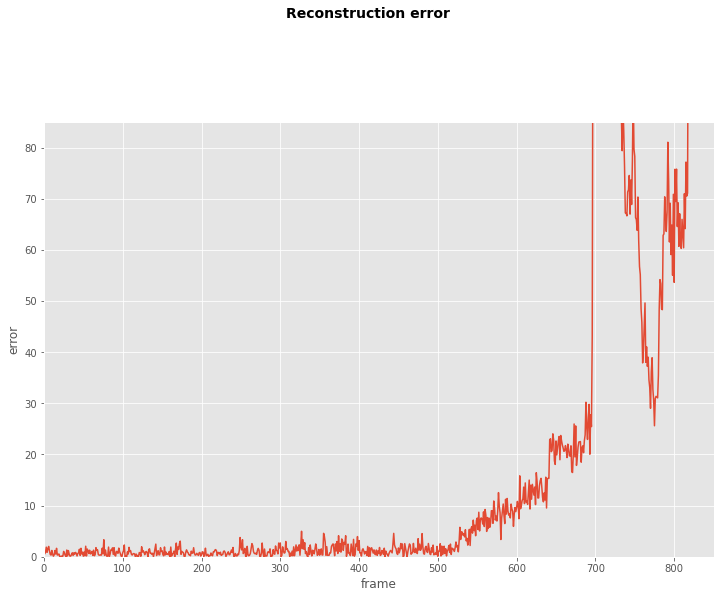

In [50]:
# evaluate the model
# calculate the reconstruction error
costs = np.zeros(x_test.shape[0])
for i, x in enumerate(x_test):
    input_x = np.reshape(x, (1, x_test.shape[1]))
    reconstruction = model.predict(input_x)
    # calculate mean squared error
    costs[i] = ((x - reconstruction[0]) ** 2).mean(axis=0)

plot_reconstruction_error(scale(costs, samples=x_train.shape[0]))